# Content Moderation and Toxicity Classification using BERT

In addition to our first method with SGD and Naive Bayes, second method with LSTMs, we are now exploring the use of BERT (Bidirectional Encoder Representations from Transformers) for label prediction in the **Jigsaw Toxic Comment Classification Dataset**.

**BERT:** It is an advanced deep learning technique used for natural language processing. Unlike previous models that processed words in a sentence sequentially (either from left to right or right to left), BERT reads the entire sequence of words at once, allowing the model to understand the context of a word based on all of its surroundings.

**Imports**

In [1]:
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import inflect
import re
import string

!pip install contractions
import contractions

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, hamming_loss

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 7.9 MB/s eta 0:00:00


In [3]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, LlamaForSequenceClassification

# Preparing Data

**1. Loading dataset**

We begin by loading the dataset. This dataset will then be used for training and testing. It includes user-generated comments with labels indicating various types of toxicity.


In [4]:
data = pd.read_csv('/content/drive/MyDrive/ML Proj/Dataset/Train/train.csv')

data = data.drop(columns = ['id'])

data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


**2. Analyzing Label Distribution in the Dataset**

The cell output indicates the distribution of labels in the dataset. It shows the total count of each label within the dataset, providing a clear indication of class imbalance, with 'toxic' being the most common label and 'threat' being the least common. This imbalance can affect the performance of machine learning models, as they tend to be better at detecting the majority class while struggling with minority classes.

Models trained on this dataset may develop a bias towards more frequently occurring labels, which can lead to **higher precision and recall** for those labels as compared to less frequent ones.


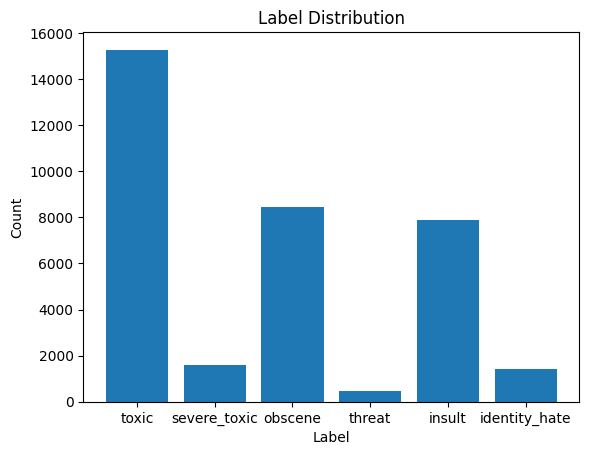

In [5]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

label_count = data.iloc[:,1:].sum()

plt.bar(labels,label_count)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

**3. Pre-processing of comments**

This function preprocess the text data from the Jigsaw Toxic Comment Classification Dataset.


*   **Removing Non-ASCII characters:** Removes non-ASCII characters to simplify text, and focus on English language words
*   **Expanding Contractions:** Replaces contraction like "can't" to "can not" for clarity and to mantain consistency
*   **Removing URLs:** Removes URLs starting with 'https', 'www'
*   **Removing Punctuations:** Remove punctuation marks from the comments as mostly they are irrelevant for the classifcation problem
*   **Removing Numbers:** Removes numbers as they aren't relevant in this classification problem
*   **Removing Stop Words:** Filters out stop words like "is", "the" and etc. These words occur frequently and offer little value for analysis

By performing these pre-processing steps, we create a cleaner and more standardized dataset that can help improve the performance of our classification models. Each step is aimed at reducing the complexity of the text data, which can lead to more efficient and effective learning by the models we use. This pre-processed data should help the model to focus on the textual patterns most relevant to identifying different forms of toxicity in online comments.








In [6]:
stop_words = set(stopwords.words('english'))

def pre_process_comments(data):
    processed_data = []

    # for idx in tqdm(range(len(data))):
    for idx in range(len(data)):
        comment = data[idx]

        # removing non-ascii characters
        comment = comment.encode('ascii', 'ignore').decode('ascii')

        # expanding contractions
        comment = contractions.fix(comment)

        # removing URLs
        comment = re.sub(r'http\S+|www\S+|https\S+', '', comment)

        # removing HTML tags
        comment = re.sub(r'<[^>]+>', '', comment)

        # removing punctuations
        comment = comment.translate(str.maketrans('', '', string.punctuation))

        # removing numbers
        comment = re.sub(r'\d+', '', comment)

        # tokenizing the words
        tokens = comment.split()

        # removing stop words and numbers
        tokens = [word for word in tokens if word not in stop_words]

        comment = ' '.join(tokens)

        processed_data.append(comment)

    return processed_data

**4. Choosing Optimal Sequence Length for the BERT model**

In this cell, we look into maximum and minimum length for the comments in our dataset.

BERT is a ‘heavy-weight’ model. This makes the training a very resource-intensive process, specially when we are fine-tuning for all model layers.

Our goal is to select a sequence length that maximizes coverage of the dataset while minimizing the need for padding and truncation, and is memory friendly.

We notice that a significant number of comments have over 72 characters, setting a sequence length just above this threshold might be a good starting point.

In [13]:
comment_lengths = []

for comment in data['comment_text']:
    comment_lengths.append(len(comment))

print('Min Comment Length:', min(comment_lengths))
print('Max Comment Length:', max(comment_lengths))
sum([1 for i in range(len(comment_lengths)) if comment_lengths[i] >= 72])

Min Comment Length: 6
Max Comment Length: 5000


130957

**4. Splitting Data into Training, Validation, and Test Sets (80:10:10)**

Proper data splitting is essential for training robust machine learning models, allowing us to assess their performance and generalize to unseen data effectively.

In [51]:
data_comp = np.asarray(data.iloc[:,0])
labels_comp = np.asarray(data.iloc[:,1:])

X_train, X_temp, y_train, y_temp = train_test_split(data_comp, labels_comp, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Validation data shape:", X_val.shape)
print("Validation labels shape:", y_val.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (127656,)
Training labels shape: (127656, 6)
Validation data shape: (15957,)
Validation labels shape: (15957, 6)
Test data shape: (15958,)
Test labels shape: (15958, 6)


**4. Tokenization and Encoding of Dataset for BERT**

In this cell, we tokenize the dataset, then generate encodings to make it suitable for processing by a BERT model. This step is critical to reduce noise and normalize the text data for better model performance.


1.   **Pre-processing**: pre_process_comments cleans the text
2.   **Tokenization + Encoding**: we add special tokens for beginning and end of sentence

**Tokenization and Encoding Details:**



*   The BERT tokenizer adds special tokens [CLS] at the start and [SEP] at the end of sentence.
*   We have set max length to 72 due to time/ memory constraints. It ensures that all tokenized outputs are padded or truncated to a consistent length, which is necessary for batching in the BERT model.


By completing these tokenization and encoding steps, we ensure that our dataset is in the optimal format for the BERT model, which can lead to better understanding and performance on the classification task. This process contributes significantly to the model's ability to accurately predict the various toxicity levels in the Jigsaw Toxic Comment Classification Dataset.






In [52]:
def tokenize_data(tokenizer, data, labels, max_length = 72):
    input_ids = []
    attention_masks = []
    data = pre_process_comments(data)

    for comment in data:
        # Tokenize and encode the comment
        encoded_dict = tokenizer.encode_plus(
                            comment,
                            add_special_tokens = True,
                            max_length = max_length,
                            truncation = True,
                            padding = 'max_length',
                            return_attention_mask = True,
                            return_tensors = 'pt'
        )
        '''
        Attention masks are binary sequences indicating the presence-1 or absence-0 of data within each tokenized input.
        They help the model pay attention to the actual content while ignoring the padded areas.
        '''

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels, dtype = torch.float32)

    return input_ids, attention_masks, labels

# Initializing the Tokenizer and BERT Model for Sequence Classification

In this section, we initialize BERT tokenizer and model, setting them up for our multi-label classification problem

We're using the 'bert-base-uncased' variant of BERT, which has been pre-trained on a large corpus of English data and is well-suited for a wide range of NLP tasks. It does not differentiate between upper and lower case, making it a versatile choice for text-based classification tasks.

Now, we are left with fine-tuning on our dataset, where the labels are not mutually exclusive and reflective of real-world conditions where a comment might exhibit multiple forms of toxicity.

In [16]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.1 MB/s eta 0:00:00


In [63]:
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig

model_name = 'bert-base-uncased'
num_labels = 6 # corresponding to ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# tokenizer
'''
It is responsible for breaking down the input text into tokens that BERT understands.
Using from_pretrained loads a tokenizer that matches the pre-trained 'bert-base-uncased' model,
ensuring compatibility between tokenization and model processing.
'''
tokenizer = BertTokenizer.from_pretrained(model_name)

# Initializing BERT model fot the 'multi_label_classification' problem
config = BertConfig.from_pretrained(model_name, num_labels=num_labels)
config.problem_type = "multi_label_classification"
model = BertForSequenceClassification.from_pretrained(model_name, config = config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Tokenizing and Encoding the Dataset for BERT Model Input**

In [64]:
# Tokenize and encode the training set
train_input_ids, train_attention_masks, train_labels = tokenize_data(tokenizer, X_train, y_train)

# Tokenize and encode the test set
test_input_ids, test_attention_masks, test_labels = tokenize_data(tokenizer, X_test, y_test)

# Tokenize and encode the validation set
validation_input_ids, validation_attention_masks, validation_labels = tokenize_data(tokenizer, X_val, y_val)

# Visualizing the Model Architecture with Netron



In [29]:
from IPython.display import SVG

display(SVG(filename='/content/bert_model.onnx.svg'))


# Creating DataLoaders for Training, Validation, and Testing



*   **TensorDataset**

    Combines the input features (input IDs and attention masks) and labels into a single dataset, which simplifies the data handling process. By doing this, we ensure that our input data and labels are aligned and can be easily batched and loaded during model training and evaluation.
    
*   **DataLoader** is a pytorch utility which allows for efficient batch processing

The use of DataLoaders facilitates efficient batch processing, which is particularly important for the fine-tuning phase.




In [65]:
from torch.utils.data import DataLoader, TensorDataset

'''
The batch size is an important hyperparameter that can affect the model's training dynamics and memory utilization.
'''
BATCH_SIZE = 64

# Create the dataset for our training, validation, and test sets.
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
validation_dataset = TensorDataset(validation_input_ids, validation_attention_masks, validation_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Create the DataLoaders for our train, validation and test sets.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # training dataset shuffled to avoid overfitting
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Inspecting a Batch of Preprocessed Data from the Training DataLoader

In this cell we extract and inspect an individual batch of data from the DataLoader. It details the batch size, the shape of input IDs, and shows an example of the encoded text, its decoded version, attention masks, and labels for one instance.

In [66]:
print('Batch Size :',train_loader.batch_size)
Batch = next(iter(train_loader))

print('Each Input ids shape :',Batch[0].shape)
print('Input ids :\n',Batch[0][0])
print('Corresponding Decoded text:\n',tokenizer.decode(Batch[0][0]))
print('Corresponding Attention Mask :\n',Batch[1][0])
print('Corresponding Label:',Batch[2][0])

Batch Size : 64
Each Input ids shape : torch.Size([64, 72])
Input ids :
 tensor([  101,  2002,  3632,  5743,  5921, 19104, 28988,  2015, 25250,  2643,
         3260,  8696, 17627,  2372, 17979,  8991, 15286,  2015,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])
Corresponding Decoded text:
 [CLS] he goes forth amongst outlaw bikers preach god mission missionary lds members preaching gentiles [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD


# Calculating the Total Number of Batches in the Training DataLoader



In [67]:
total_samples = len(train_dataset)  # Total number of samples in the dataset
batch_size = train_loader.batch_size  # Batch size used in DataLoader
expected_batches = total_samples / batch_size  # Expected number of batches

print(f"Total samples: {total_samples}")
print(f"Batch size: {batch_size}")
print(f"Expected number of training batches: {int(expected_batches)}")


Total samples: 127656
Batch size: 64
Expected number of training batches: 1994


# Setting Up the Loss Function and Optimizer for BERT Model Training

*   **BCEWithLogitsLoss**: This loss function is ideal for multi-label classification tasks, where each label is independent and not mutually exclusive. It combines a sigmoid layer and the binary cross-entropy loss in one single class.
*   **AdamW:** It applies weight decay in a manner that is more effective for complex models like BERT. This leads to better generalization (less overfitting) during training.



In [68]:
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss

# loss function
loss_fn = BCEWithLogitsLoss()

# optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

In [69]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Training and Validation for Fine-Tuning the BERT model

This cell contains the training and validation loop for fine-tuning the BERT model on our multi-label classification task. It iterates over the dataset for a set number of epochs, updating the model parameters based on the training data and evaluating the model's performance on the validation data on a regular basis.

To balance training Time and model performance, we choose to do **three** iterations only. More epochs can lead to overfitting, especially if the training dataset is like our's - imbalanced. This approach is particularly effective in the exploratory phases of model development, where the goal is to understand the model's behavior and potential rather than fully optimizing its performance.

In [70]:
def train(model, train_loader, val_loader, optimizer, loss_fn, num_epochs, train_losses, val_losses):
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0

        for idx, batch in enumerate(train_loader):
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            # Gradients are zeroed out using optimizer.zero_grad() to prevent accumulation from previous iterations.
            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = loss_fn(outputs.logits, labels)

            # Backward propagation is done to compute gradients
            loss.backward()

            # Updates the model parameters
            optimizer.step()

            running_loss += loss.item()

            if idx % 500 == 0 or idx + 1 == len(train_loader):
                print(f"Loss after epoch {epoch + 1}: mini-batch {idx}: {loss.item():.4f}")


        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Average training loss for Epoch {epoch+1}: {avg_train_loss:.4f}")

        # Validation
        model.eval() # model set to evaluation mode
        running_val_loss = 0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch[0].to(device)
                attention_mask = batch[1].to(device)
                labels = batch[2].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = loss_fn(outputs.logits, labels)

                running_val_loss += loss.item()

                logits = outputs.logits
                predictions = torch.round(torch.sigmoid(logits))
                correct_predictions += torch.sum(predictions == labels).item()
                total_predictions += labels.size(0) * labels.size(1)

        val_accuracy = correct_predictions / total_predictions

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Average validation loss for Epoch {epoch+1}: {avg_val_loss:.4f} Validation Accuracy: {val_accuracy}")
        print("..............................................")

    # Return the trained model
    return model

train_losses = []
val_losses = []
model = train(model.to(device), train_loader, validation_loader, optimizer, loss_fn, 3, train_losses, val_losses)

Loss after epoch 1: mini-batch 0: 0.6965
Loss after epoch 1: mini-batch 500: 0.0282
Loss after epoch 1: mini-batch 1000: 0.0394
Loss after epoch 1: mini-batch 1500: 0.0505
Loss after epoch 1: mini-batch 1994: 0.0714
Average training loss for Epoch 1: 0.0601
Average validation loss for Epoch 1: 0.0421 Validation Accuracy: 0.9841239999164421
..............................................
Loss after epoch 2: mini-batch 0: 0.0326
Loss after epoch 2: mini-batch 500: 0.0190
Loss after epoch 2: mini-batch 1000: 0.0269
Loss after epoch 2: mini-batch 1500: 0.0171
Loss after epoch 2: mini-batch 1994: 0.1169
Average training loss for Epoch 2: 0.0372
Average validation loss for Epoch 2: 0.0421 Validation Accuracy: 0.9832466420170876
..............................................
Loss after epoch 3: mini-batch 0: 0.0418
Loss after epoch 3: mini-batch 500: 0.0393
Loss after epoch 3: mini-batch 1000: 0.0425
Loss after epoch 3: mini-batch 1500: 0.0199
Loss after epoch 3: mini-batch 1994: 0.0255
Averag

# Plotting Losses over Epochs

In this cell, we visually represnt the training loss of the BERT model across the epochs.

The plot shows a downward trend, indicating that the model's loss is decreasing over time and thus learning from the training data

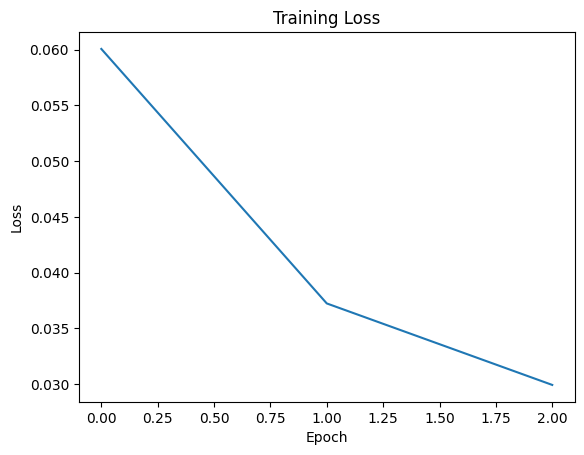

In [71]:
# plot train losses
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Evaluation

We're now done with the training part. To evaluate its performace, we will use test data to make predictions, and compare these predictions to the actual labels. It helps in understanding how well the model generalizes to unseen data.
The evaluation metrics we will use are:

**Accuracy:** To measure how often the model predicts the correct labels across all classes.

**Binary Cross Entropy Loss:** To account for the proportion of misclassified labels, which is important in multi-label classification tasks.

**Classification Report:** To get detailed insights into the precision, recall, and F1-score for each individual label, which helps us understand the model's strengths and weaknesses for each type of label..

In [73]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_recall_curve, auc, multilabel_confusion_matrix
import seaborn as sns

def evaluate_model(model, test_loader):
    # set to evaluation mode: ensures that the model's dropout layers and other training-specific functionalities are disabled.
    model.eval()
    running_loss = 0
    true_labels = []
    predictions_list = []
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for idx, batch in enumerate(test_loader):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits

            predictions = torch.round(torch.sigmoid(logits))
            correct_predictions += torch.sum(predictions == labels).item()
            total_predictions += labels.size(0)*labels.size(1)

            predictions_list.append(predictions.cpu().numpy())
            true_labels.append(labels.cpu().numpy())

        return np.concatenate(true_labels), np.concatenate(predictions_list)

y_true, y_pred = evaluate_model(model, test_loader)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

# Generate a classification report for detailed metrics
class_report = classification_report(y_true, y_pred, target_names=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"], zero_division=0)
print(class_report)

Accuracy: 0.9241759618999875
               precision    recall  f1-score   support

        toxic       0.79      0.84      0.81      1520
 severe_toxic       0.65      0.14      0.22       162
      obscene       0.83      0.84      0.83       856
       threat       0.52      0.35      0.42        37
       insult       0.81      0.74      0.77       808
identity_hate       0.64      0.47      0.54       138

    micro avg       0.80      0.76      0.78      3521
    macro avg       0.71      0.56      0.60      3521
 weighted avg       0.79      0.76      0.77      3521
  samples avg       0.07      0.07      0.07      3521



**Model Perfomance Analysis:**

The model has a overall accuracy of 92.4%, suggesting that the model performs well for the majority of predictions. However, examining the recall values, especially for less represented classes such as 'threat' and 'identity_hate', reveals that the model struggles to identify these rarer cases. While accuracy is a useful indicator, it does not always provide the full picture, especially in an imbalanced dataset. Therefore, we delve deeper into the precision, recall, and F1-scores to gauge the model's performance across individual classes.

For toxic comments, f1-score is 0.81, which vows for high precision and recall. Despite, precision of 0.65, severe_toxic label havea very low recall. This suggests that while the model is relatively confident when it identifies a comment as severely toxic, it misses a significant number of such instances. Similarly, for other labels such as threat and identity_hate precision is moderate but recall is low.

Low recall values suggests that model is failing to identify a significant portion of the minority classes. This can be attributed to the fact that our dataset is **imbalanced**. This results in minority classes being not adequately learned by the model, leading to more false negatives.


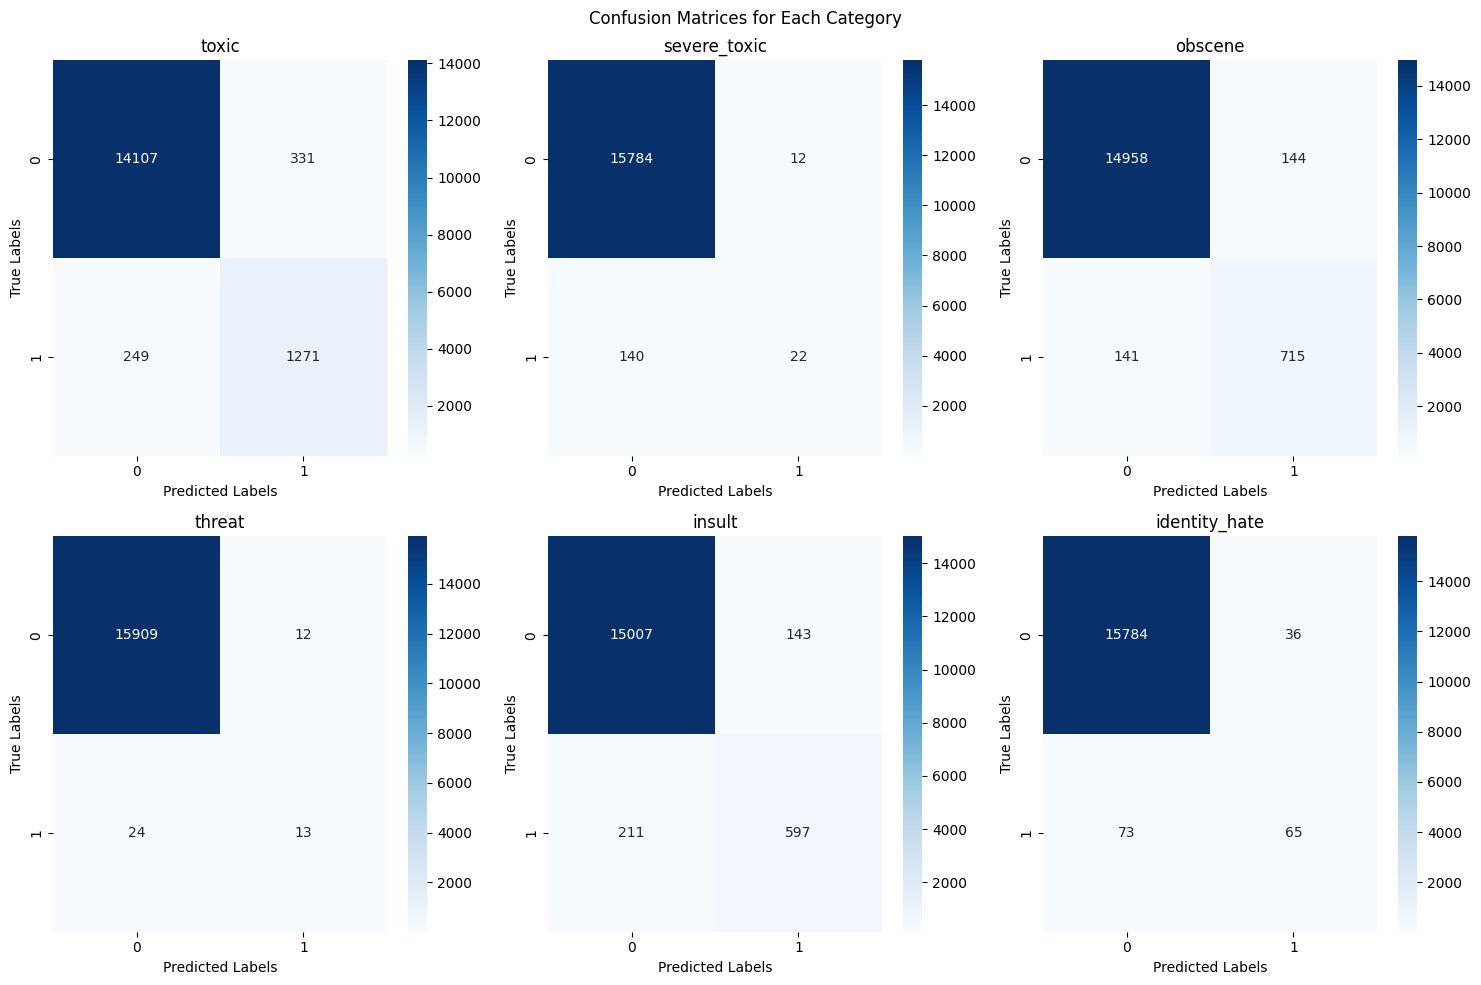

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# Assuming y_true and y_pred are your true and predicted labels as numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute the multilabel confusion matrix
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)

# Plotting each confusion matrix
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the layout based on your preference
fig.suptitle('Confusion Matrices for Each Category')

label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

for i, cm in enumerate(confusion_matrices):
    ax = axes.flatten()[i]
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(label_names[i])
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


In [104]:
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

# Placeholder for y_true and y_pred which should be your dataset's labels
# y_true should be a binary matrix with shape (n_samples, n_classes)
# y_pred should be the predicted probabilities with the same shape
# y_true = ...
# y_pred = ...

# Calculate ROC AUC for each label
roc_auc_scores = [roc_auc_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])]

# Calculate the Average Precision Score for each label
avg_precision_scores = [average_precision_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])]

# Calculate the macro average for ROC AUC and Average Precision
macro_roc_auc = np.mean(roc_auc_scores)
macro_avg_precision = np.mean(avg_precision_scores)

# Print out the results
print("ROC AUC Scores for each label:", roc_auc_scores)
print("Average Precision Scores for each label:", avg_precision_scores)
print(f"Macro Average ROC AUC Score: {macro_roc_auc}")
print(f"Macro Average Precision Score: {macro_avg_precision}")


ROC AUC Scores for each label: [0.9066292987802655, 0.5675213915696738, 0.9128726064629678, 0.6752988149257227, 0.8647112211221123, 0.734369446123967]
Average Precision Scores for each label: [0.6790180231118875, 0.09664521511305595, 0.7040923494464986, 0.18420665056584345, 0.6093036238707689, 0.3077026469845664]
Macro Average ROC AUC Score: 0.7769004631641181
Macro Average Precision Score: 0.43016141818210346


This section draws inspiration from another Kaggle notebook. Despite the fact that the metrics of our evaluation measures have already been discussed above.

The ROC AUC and Average Precision scores for each label provide a nuanced view of the model's performance. A high ROC AUC score suggests good separability between the positive and negative classes, indicating the model's effectiveness at distinguishing different classes. The Average Precision score gives us insight into the model's precision-recall balance, which is particularly important in multi-label classification where each instance can belong to multiple classes.

- **ROC AUC Scores**: The values range from approximately 0.57 to 0.91 across different labels. Higher scores (closer to 1.0) indicate better performance in correctly ranking positive instances above negatives. The variation among scores reflects the varying degrees of difficulty the model faces in distinguishing each class.

- **Average Precision Scores**: These scores range from about 0.18 to 0.96, revealing a significant disparity in the model's precision across labels. Lower scores may indicate a higher number of false positives, which can be particularly challenging in an imbalanced dataset where the minority class has fewer instances to learn from.

- **Macro Averages**: The Macro Average ROC AUC Score is 0.77, and the Macro Average Precision Score is 0.43. The macro averages treat all labels equally, providing an average score across all classes without taking label imbalance into account. The relatively lower macro average precision score suggests that there are labels for which the model has a lower precision, potentially due to class imbalance.

To address these disparities, especially for labels with lower scores, strategies such as resampling, cost-sensitive learning, or tailored threshold adjustment might be necessary. These methods can help improve the model's recall and precision, particularly for the underrepresented classes.


# Text Classification with the Trained Model

In this final section, we will use our trained model to classify new input text. This involves several key steps:



1.   Pre-processing the input
2.   Tokenizing the pre-processed input
3. Model Prediction
4. Interpretation of the output

In [96]:
def predict_input(input, model, tokenizer):
    input = [input]
    input = pre_process_comments(input)
    user_encodings = tokenizer(input, truncation=True, padding=True, return_tensors="pt")
    user_dataset = TensorDataset(user_encodings['input_ids'], user_encodings['attention_mask'])

    user_loader = DataLoader(user_dataset, batch_size=1, shuffle=False)

    model.eval()
    with torch.no_grad():
        for batch in user_loader:
            input_ids, attention_mask = [t.to(device) for t in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.round(torch.sigmoid(logits))

            pred_labels = predictions.squeeze().tolist()

            labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
            txt_pred = [label for label, pred in zip(labels, pred_labels) if pred == 1]

            return txt_pred


In [92]:
input_text = "Fat man go eat with your nigga brother"
predicted_labels = predict_input(input_text, model, tokenizer)
print("Predicted labels:", predicted_labels)

Predicted labels: ['toxic', 'insult', 'identity_hate']


In [101]:
input_text = "I'll blow you and the tower with guns"
predicted_labels = predict_input(input_text, model, tokenizer)
print("Predicted labels:", predicted_labels)

Predicted labels: ['toxic', 'threat']


In [97]:
input_txt = "Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"
predicted_labels = predict_input(input_text, model, tokenizer)
print("Predicted labels:", predicted_labels)

Predicted labels: ['toxic', 'obscene', 'insult', 'identity_hate']


This model outperforms every other model. It precisely determines the presence of all toxic elements in the output. Additional details are provided above and in the report.